# IMDB Movie rating Data Analysis



## About the notebook

In this notebook we are going to analyze and visualize data to understand the key characteristics, uncover patterns, and identify relationships between attributes of movies basedof imdb dataset that has been gatherd in the proir part using web scraping  

## Import libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

## Preprocessing Data :

Most effort of this part refers to cleaning the data. The features that are need to be cleaned
- **duration** : Duration on the movies are saved in this format 'hour'h 'minute'm for example 2h 30m. We convert the movie duration to minutes to be able to treat this feature as numerical.

- **Meta score** : Change the type to int from string.

- **Number of vote**: This feature is saved in this format 'num1'M 'num2'K for example 2M 30K which is equal to 2030000. This feature needs to be written in numerical feature.

- **Budget**: We need to convert all the budgets to USD.

- **Gross**

### Convert duration of all movies to minute  

In [2]:
df = pd.read_csv("imdb.csv")

def convert_duration(duration):
    parts = duration.split()
    total_minutes = 0
    for part in parts:
        if 'h' in part:
            total_minutes += int(part.rstrip('h')) * 60
        elif 'm' in part:
            total_minutes += int(part.rstrip('m'))
    return total_minutes

df['Duration'] = df['Duration'].apply(convert_duration)

print(df['Duration'])


0       142
1       152
2       148
3       139
4       142
       ... 
4718     95
4719    115
4720    119
4721    139
4722    112
Name: Duration, Length: 4723, dtype: int64


In [3]:
df['Meta Score'] = df['Meta Score'].astype(int)

### Number of vote preprocessing

In [4]:
def convert_votes(votes_str):
    if 'K' in votes_str:
        return int(float(votes_str.rstrip('K')) * 1000)
    elif 'M' in votes_str:
        return int(float(votes_str.rstrip('M')) * 1000000)
    else:
        return int(votes_str)

df['Number of Votes'] = df['Number of Votes'].apply(convert_votes)

### Budget Preprocessing

In the dataset most of the budgets movie has been written in USD. We want to convert all of the budjets to USD to have a unique numerical variable.   

### Gross world wide feature

For clean this feature we should:

 - Remove $ sign.
 - Clean the budget value:
    Every 3 digits of budget has been seperated with ','. for example $200,500,000. It must convert to $20050000 

In [5]:
def convert_currency(value):
    if isinstance(value, str) and value.startswith('$'):
        return int(value.replace('$', '').replace(',', ''))
    else:
        return value

df['Gross (worldwide)'] = df['Gross (worldwide)'].apply(convert_currency)

### Budget Feature

The budget feature has the problem to So we must clean the budget value.

In [6]:
def clean_budget_value(value):
        return str(value.replace(',', ''))
    
df['Budget'] = df['Budget'].apply(clean_budget_value)

All of the budgets are not in USD. The 'Budget' column contains various currency symbols. In this block of code we print them.

In [7]:
def extract_prefix(budget):
    match = re.match(r'([^\d]+)', str(budget).strip())
    if match:
        return match.group(1)
    return None


df['Prefix'] = df['Budget'].apply(extract_prefix)
unique_prefixes = df['Prefix'].dropna().unique()

unique_prefixes_list = unique_prefixes.tolist()
print(unique_prefixes_list)

['$', 'FRF\xa0', '€', '£', 'R$', '₹', '¥', 'DKK\xa0', 'DEM\xa0', '₩', 'CA$', 'RUR\xa0', 'ITL\xa0', 'CN¥', 'NOK\xa0', 'ATS\xa0', 'A$', 'SEK\xa0', 'BEF\xa0', 'THB\xa0', 'NZ$', 'SGD\xa0', 'HUF\xa0']


These prefixes appear to be international currency symbols and codes. The presence of non-breaking space characters (\xa0) indicates that some of the prefixes include a space character that might need to be cleaned up.

To convert the currency budget to USD, we'll need to use exchange rates for each currency.

Here’s a step-by-step approach:

1. **Define exchange rates** for each currency symbol.
2. **Extract the numeric part** and **currency prefix**.
3. **Convert the values** to USD using the exchange rates.
4. **Create a new column** with the converted value

In [8]:
exchange_rates = {
    '$': 1.0,       # USD to USD 
    'FRF': 0.17,    # French Franc to USD
    '€': 1.1,       # Euro to USD
    '£': 1.3,       # British Pound to USD
    'R$': 0.2,      # Brazilian Real to USD
    '₹': 0.012,     # Indian Rupee to USD
    '¥': 0.0073,    # Japanese Yen to USD
    'DKK': 0.15,    # Danish Krone to USD
    'DEM': 0.51,    # German Mark to USD
    '₩': 0.00079,   # South Korean Won to USD
    'CA$': 0.78,    # Canadian Dollar to USD
    'RUR': 0.014,   # Russian Ruble to USD
    'ITL': 0.00058, # Italian Lira to USD
    'CN¥': 0.16,    # Chinese Yuan to USD
    'NOK': 0.1,     # Norwegian Krone to USD
    'ATS': 0.08,    # Austrian Schilling to USD
    'A$': 0.76,     # Australian Dollar to USD
    'SEK': 0.12,    # Swedish Krona to USD
    'BEF': 0.027,   # Belgian Franc to USD
    'THB': 0.031,   # Thai Baht to USD
    'NZ$': 0.70,    # New Zealand Dollar to USD
    'SGD': 0.74,    # Singapore Dollar to USD
    'HUF': 0.0034   # Hungarian Forint to USD
}

def extract_currency_and_amount(budget):
    budget = str(budget).replace('\xa0', ' ').strip()
    match = re.match(r'([^\d\s]+)?\s?(\d+)', budget)
    if match:
        prefix = match.group(1)
        amount = match.group(2)
        return prefix, float(amount)
    return None, None

def convert_to_usd(prefix, amount):
    if prefix in exchange_rates:
        return amount * exchange_rates[prefix]
    return amount

df['Prefix'], df['Amount'] = zip(*df['Budget'].apply(extract_currency_and_amount))
df['Budget'] = df.apply(lambda row: convert_to_usd(row['Prefix'], row['Amount']), axis=1)
df = df.drop(columns=['Prefix', 'Amount'])

print(df['Budget'])

0        25000000.0
1       185000000.0
2       160000000.0
3        63000000.0
4        55000000.0
           ...     
4718     21150000.0
4719     13000000.0
4720      5850000.0
4721     30000000.0
4722     36000000.0
Name: Budget, Length: 4723, dtype: float64


### Reduce Budget and gross Digits
These numbers in the budget and gross are too big, compromising its readability. Let's convert the unit of the budget and gross columns from $ to million $ first.

In [9]:
df['Budget'] = df['Budget']/1000000
df['Gross (worldwide)'] = df['Gross (worldwide)']/1000000

df[['Budget', 'Gross (worldwide)']].describe()

,Budget,Gross (worldwide)
count,4723.000000,4723.000000
mean,41.263305,128.234328
std,47.449216,209.435145
min,0.001560,0.000126
25%,10.000000,19.004232
50%,25.000000,55.404207
75%,54.000000,147.907361
max,356.000000,2923.706026


In [10]:
print(df['Budget'])

0        25.00
1       185.00
2       160.00
3        63.00
4        55.00
         ...  
4718     21.15
4719     13.00
4720      5.85
4721     30.00
4722     36.00
Name: Budget, Length: 4723, dtype: float64


### Adding profit feature

The profit of a movie is a crusial measure for investor. In this notebook There are many analyzes to see the attributes of beneficial movies.

After cleaning the budget and world wide gross feature we can easily calculate the profit of movie. It contains the difference of the two columns: gross and budget.

In [11]:
df['profit'] = df['Gross (worldwide)'] - df['Budget']
print(df['profit'])
df.describe()   

0         3.906619
1       823.486720
2       679.030630
3        38.320107
4       623.226465
           ...    
4718     18.288674
4719     17.947403
4720      5.686119
4721      3.448971
4722     68.404248
Name: profit, Length: 4723, dtype: float64


,Release Year,Duration,Rating,Number of Votes,Meta Score,Budget,Gross (worldwide),profit
count,4723.000000,4723.000000,4723.000000,4.723000e+03,4723.000000,4723.000000,4723.000000,4723.000000
mean,2003.634131,111.319500,6.661211,1.730934e+05,57.971840,41.263305,128.234328,86.971024
std,13.426662,20.303296,0.930746,2.319778e+05,17.924634,47.449216,209.435145,178.910050
min,1950.000000,63.000000,1.500000,2.600000e+04,1.000000,0.001560,0.000126,-199.821857
25%,1997.000000,97.000000,6.100000,5.000000e+04,45.000000,10.000000,19.004232,0.880617
50%,2006.000000,108.000000,6.700000,9.400000e+04,58.000000,25.000000,55.404207,28.117303
75%,2013.000000,121.000000,7.300000,1.960000e+05,71.000000,54.000000,147.907361,97.340566
max,2024.000000,321.000000,9.300000,2.900000e+06,100.000000,356.000000,2923.706026,2686.706026


In [12]:
df.to_csv("preprocessed_imdb.csv", index=False)

## EDA : 

### Correlation Matrix for our numeric columns :

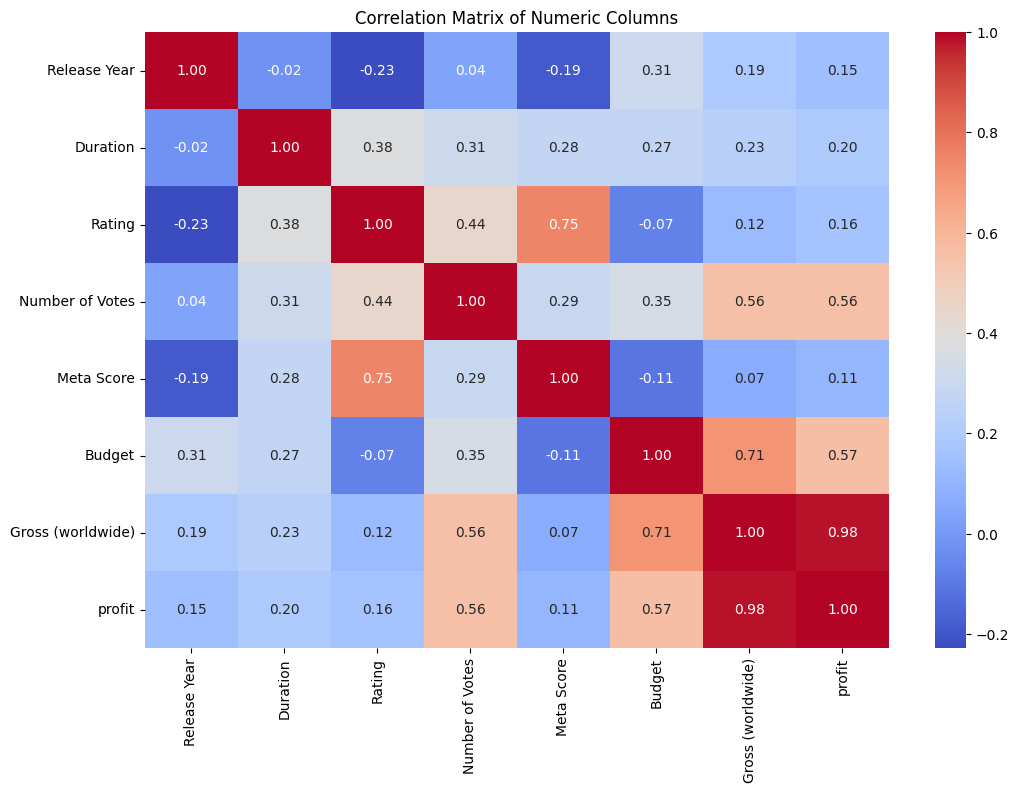

In [13]:
df = pd.read_csv("preprocessed_imdb.csv")

numeric_columns = df.select_dtypes(include=['int64', 'float64'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

#### Observations
This plot defines the correlation between features. By analysing this graph we can clearly understand 
- The proft , gross , budget and number of votes are highly dependable.
- The Rating and Meta score are highly dapendable.

### Profit and budget

By plotting the scatter plot and histogram of profit and budget we are going to visualize the relation of these features.

First we sort the dataset by profit in descending order.
 

In [14]:
sotredprofit_movies = df.sort_values(by='profit' , ascending=False)
sotredprofit_movies.head()

,Title,Release Year,Age Restriction,Duration,Genre,Rating,Number of Votes,Meta Score,Language,Country of Origin,Companies,Budget,Gross (worldwide),profit
29,Avatar,2009,PG-13,162,Action~Adventure~Fantasy,7.9,1400000,83,English~Spanish,United States,Twentieth Century Fox~Dune Entertainment~Light...,237.0,2923.706026,2686.706026
36,Avengers: Endgame,2019,PG-13,181,Action~Adventure~Drama,8.4,1300000,78,English~Japanese~Xhosa~German,United States,Marvel Studios~Walt Disney Pictures,356.0,2799.439100,2443.439100
34,Titanic,1997,PG-13,194,Drama~Romance,7.9,1300000,75,English~Swedish~Italian~French,United States~Mexico,Twentieth Century Fox~Paramount Pictures~Light...,200.0,2264.750694,2064.750694
323,Avatar: The Way of Water,2022,PG-13,192,Action~Adventure~Fantasy,7.6,493000,67,English,United States,20th Century Studios~TSG Entertainment~Lightst...,350.0,2320.250281,1970.250281
73,Star Wars: Episode VII - The Force Awakens,2015,PG-13,138,Action~Adventure~Sci-Fi,7.8,973000,80,English,United States,Lucasfilm~Bad Robot,245.0,2071.310218,1826.310218


<Figure size 800x600 with 0 Axes>

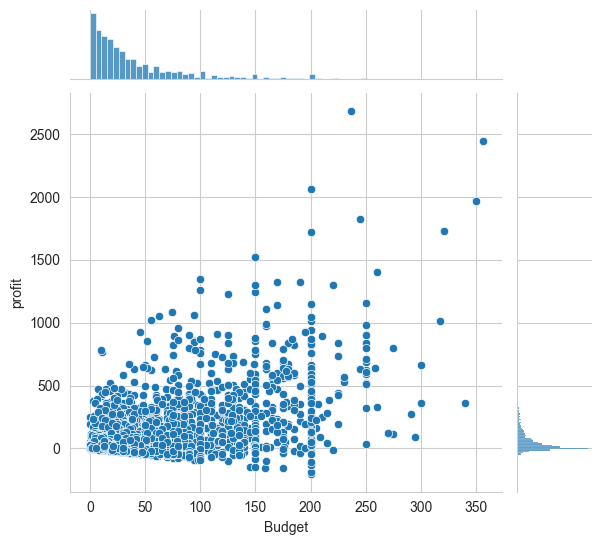

In [15]:
sns.set_style('whitegrid')

plt.figure(figsize=[8,6])
h= sns.jointplot(x='Budget', y='profit' , data=df)
plt.subplots_adjust(top=0.9)
plt.show()

#### Observations

- Most of movies were profitable.
- Both Budget and profit are slightly skewd to right which means most of the movies had positive profit.
- There is a positive relation between profit and budget.

### Profitable movies.

A new feature is added named isProfitable that is for recognizing the movies that has positive or negative profit. The positive profit is defined when the profid is greater than the double of our budget.

In [16]:
df['isProfitable'] = df['profit'] > (df['Budget']*2)

### Profitable and unprofitable movies properties

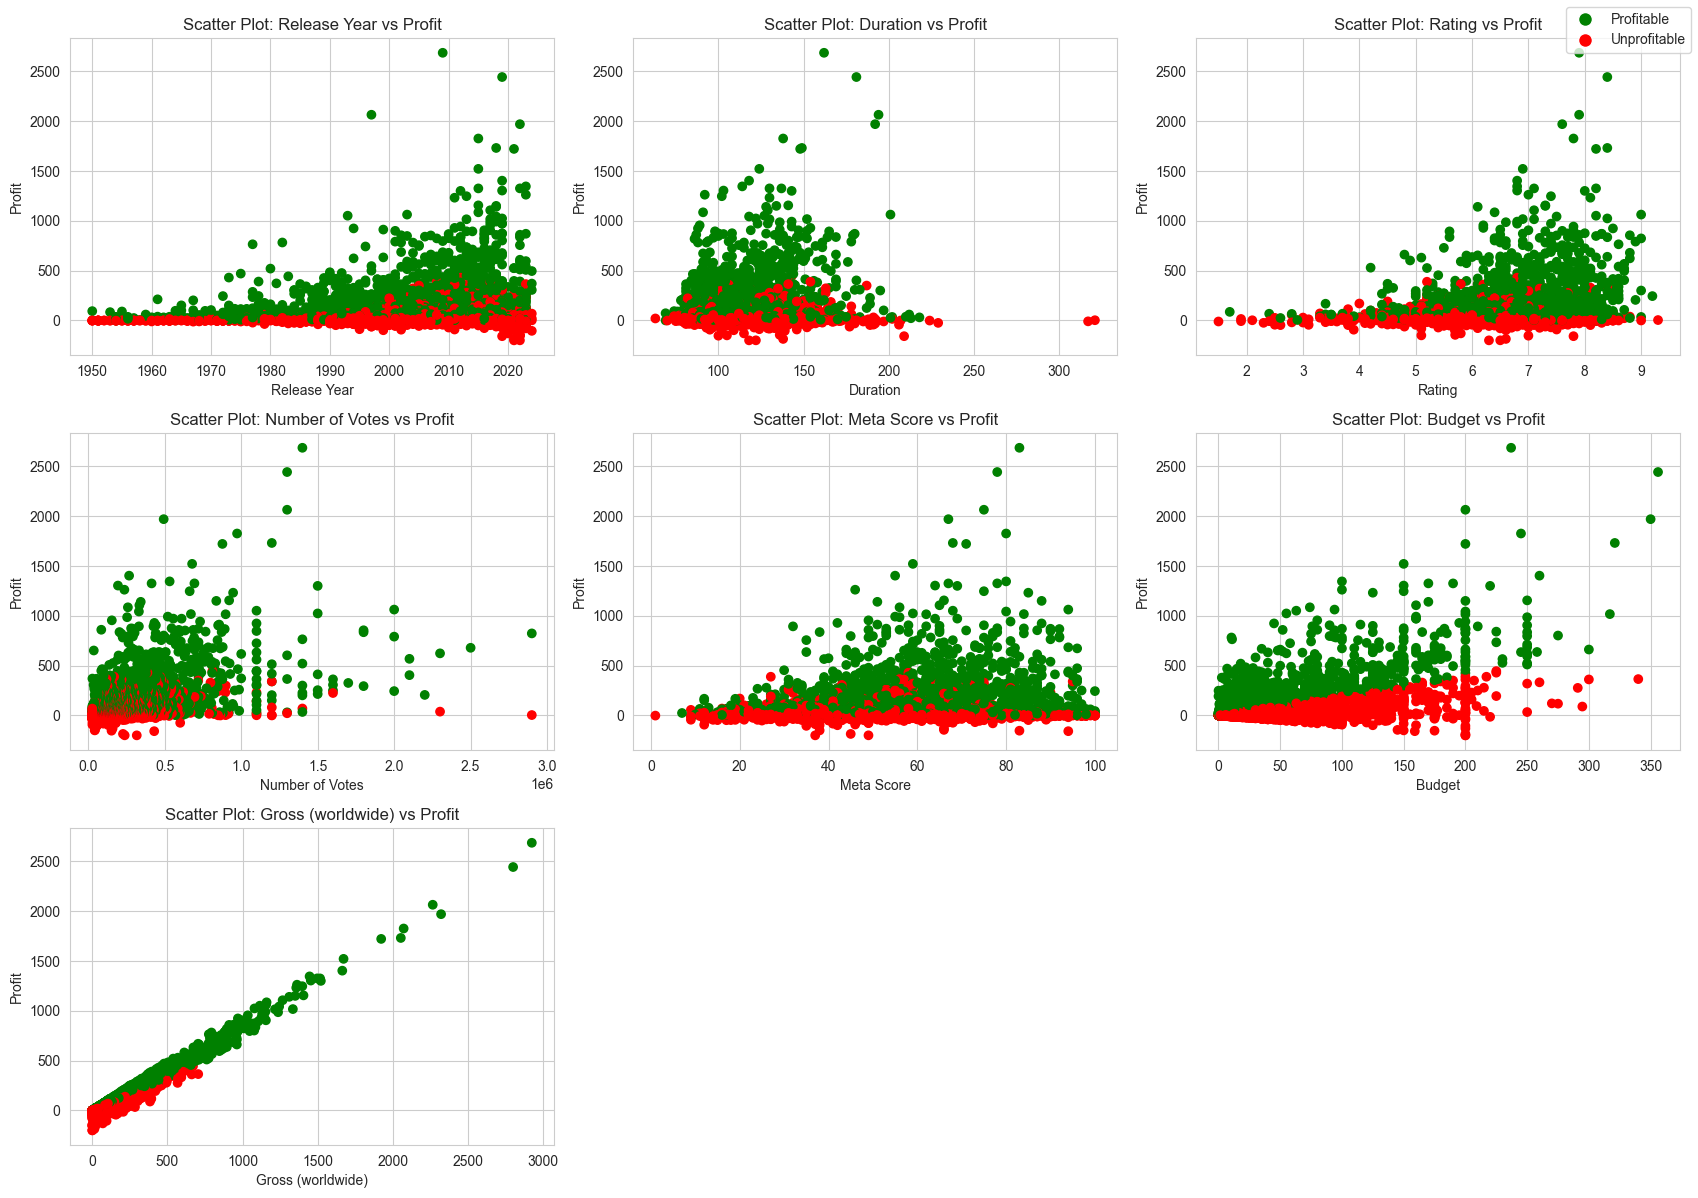

In [17]:
features = ['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score', 'Budget', 'Gross (worldwide)']

def plot_scatter_with_legend(df, features):
    plt.figure(figsize=(17,12))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        plt.scatter(df[feature], df['profit'], c=df['isProfitable'].map({True: 'green', False: 'red'}))
        plt.xlabel(feature)
        plt.ylabel('Profit')
        plt.title(f'Scatter Plot: {feature} vs Profit')

    labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)]
    
    plt.figlegend(labels, ['Profitable', 'Unprofitable'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_scatter_with_legend(df, features)

#### Observations
- In the profit vs release years are skewed to the left which means as time passed directors are better in producing profitable movies. 
- In the profit and rating plot datums are skewed to the left which means If the rating is higher, there is a lower chance that the film is unprofitable.
- In the Profit vs Meta Score chart, we can see that at around 750 to 1000 million dollars, we get scores ranging from 40 to 90, indicating that the profitability of a movie is quite independent of the movie score since we get the same number of unprofitable and profitable movies.

Now lets see the percentage of profitable and unprofitable movies for each feature.

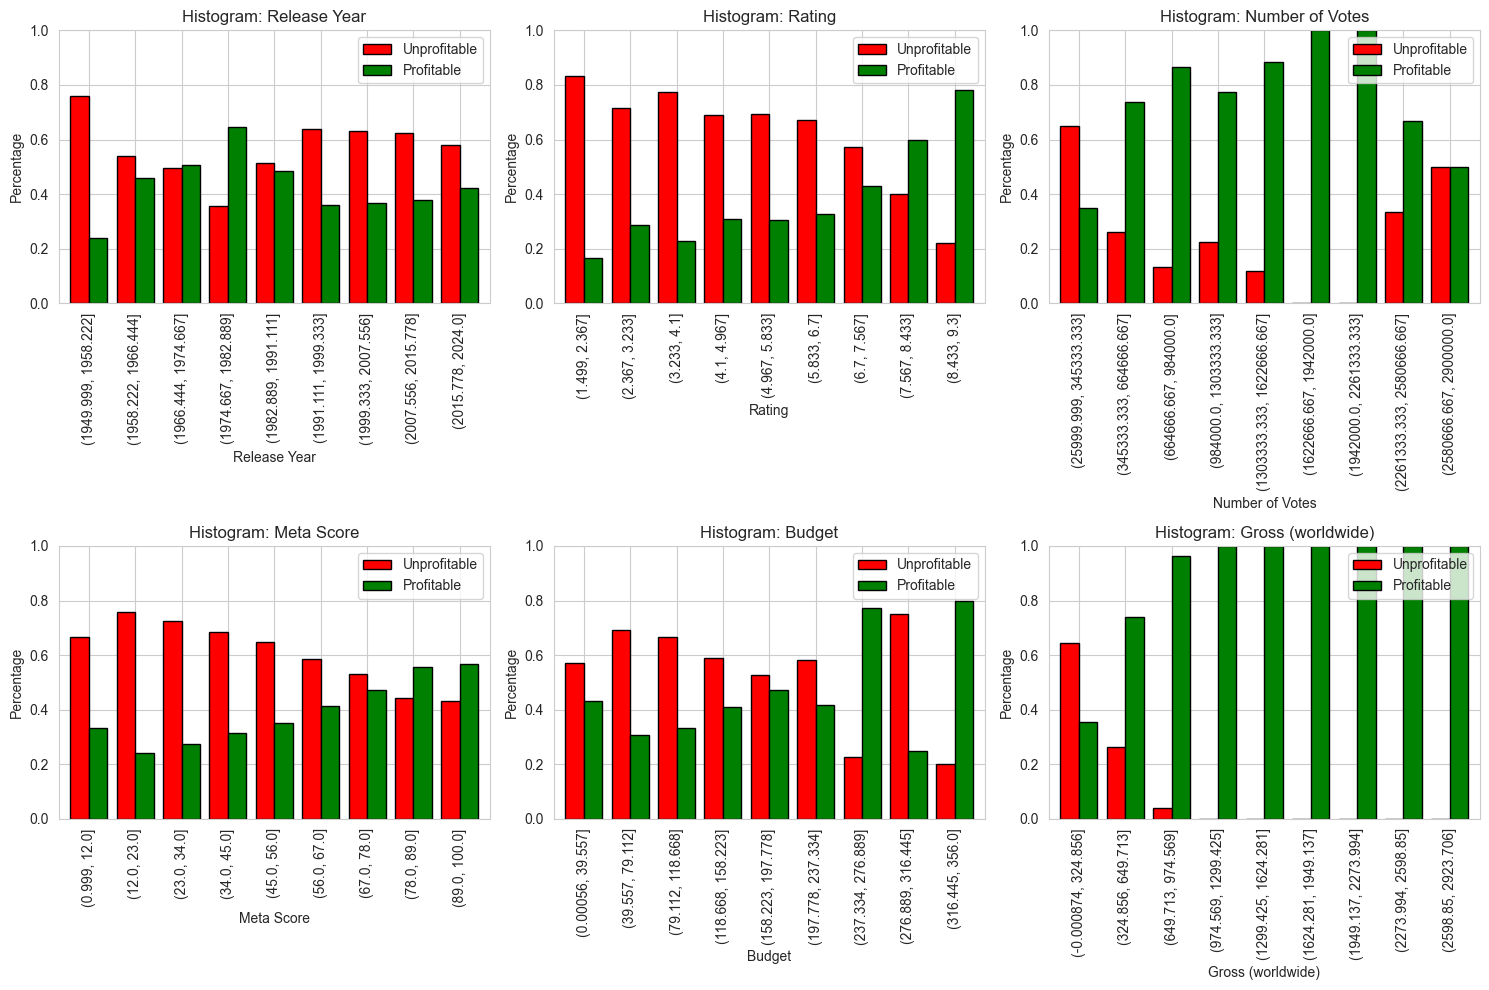

In [18]:
features = ['Release Year', 'Rating', 'Number of Votes', 'Meta Score', 'Budget', 'Gross (worldwide)']

def plot_histograms(df, features):
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        bins = np.linspace(df[feature].min(), df[feature].max(), 10)
        df['bin'] = pd.cut(df[feature], bins, include_lowest=True)
        
        bin_counts = df.groupby('bin')['isProfitable'].value_counts(normalize=True).unstack().fillna(0)
        
        bin_counts.plot(kind='bar', color=['red', 'green'], ax=plt.gca(), width=0.8, edgecolor='k')
        
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.title(f'Histogram: {feature}')
        plt.ylim(0, 1)
        plt.legend(['Unprofitable', 'Profitable'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_histograms(df, features)

#### Observations
- The propation of unprofitable movies decrease as the rating and metascore increases.
- The proporation of unprofitable has a incresing pulse in the past years.


##### Further investigation : 

Above the $237 million budget for movies, we can see a very high proportion of profitable movies. However, there appears to be an outlier in the range from $276 to $316 million. To investigate this further, we should consider analyzing these movies to better understand what went wrong.

In [19]:
budget_range_df = df[(df['Budget'] >= 276) & (df['Budget'] <= 316)]
budget_range_df

,Title,Release Year,Age Restriction,Duration,Genre,Rating,Number of Votes,Meta Score,Language,Country of Origin,Companies,Budget,Gross (worldwide),profit,isProfitable,bin
183,Pirates of the Caribbean: At World's End,2007,PG-13,169,Action~Adventure~Fantasy,7.1,693000,50,English,United States,Walt Disney Pictures~Jerry Bruckheimer Films~S...,300.0,961.691209,661.691209,True,"(649.713, 974.569]"
341,Justice League,2017,PG-13,120,Action~Adventure~Fantasy,6.1,478000,45,English~Irish Gaelic~Russian~Icelandic,United States~Canada~United Kingdom,Warner Bros.~RatPac Entertainment~DC Entertain...,300.0,661.326987,361.326987,False,"(649.713, 974.569]"
907,Mission: Impossible - Dead Reckoning Part One,2023,PG-13,163,Action~Adventure~Thriller,7.7,246000,81,English~French~Italian~Russian,United States,Paramount Pictures~Skydance Media~TC Productions,291.0,567.535383,276.535383,False,"(324.856, 649.713]"
1169,Indiana Jones and the Dial of Destiny,2023,PG-13,154,Action~Adventure~Sci-Fi,6.5,198000,58,"English~German~Greek, Ancient (to 1453)~Spanis...",United States,Walt Disney Pictures~Lucasfilm~Paramount Pictures,294.7,383.963057,89.263057,False,"(324.856, 649.713]"


We can see there are titles like Justice League	or Indiana Jones and the Dial of Destiny where **Justice League** underperformed due to rushed team-up, unkind reviews, and production issues and **Indiana Jones and the Dial of Destiny** wasn't profitable due to high production budget, skepticism from previous installment, change of director, and underperformance at the box office.

### Top 10 Companies with most profit 

Companies
South Pictures                      1731.415039
Jason Roberts Productions           1731.415039
LuckyChap Entertainment             1345.638421
Nintendo                            1262.052250
Vita-Ray Dutch Productions (III)     905.046416
Pascal Pictures                      894.446476
Gadget Films                         870.159540
Walt Disney Studios                  862.630120
Lightstorm Entertainment             845.437040
Marzano Films                        791.041698
Name: profit, dtype: float64


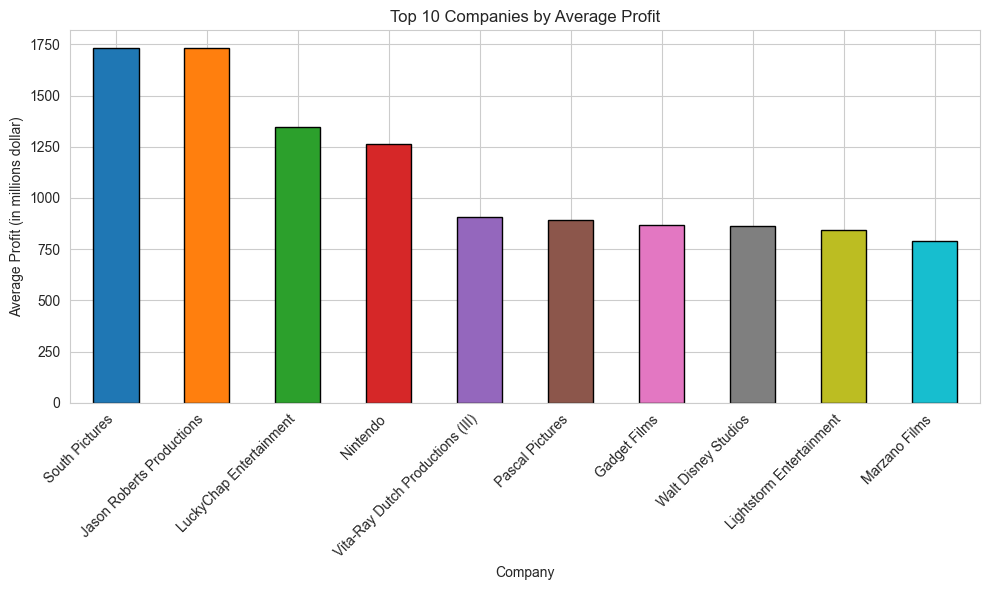

In [23]:
companies_profit_data = df[['Companies', 'profit']].copy()

companies_profit_data['Companies'] = companies_profit_data['Companies'].str.split('~')
companies_profit_data = companies_profit_data.explode('Companies')

company_avg_profit = companies_profit_data.groupby('Companies')['profit'].mean().sort_values(ascending=False)

print(company_avg_profit.head(10))

top_10_companies = company_avg_profit.head(10)

colors = plt.cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 6))
top_10_companies.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Companies by Average Profit')
plt.xlabel('Company')
plt.ylabel('Average Profit (in millions dollar)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Top Generes with most profit

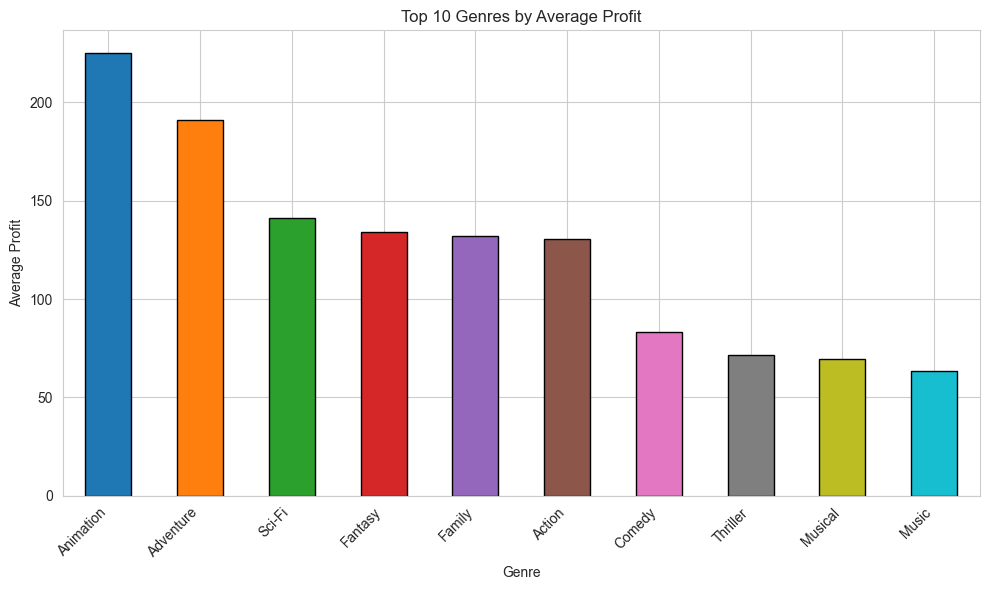

In [26]:
genres_profit_data = df[['Genre', 'profit']].copy()

genres_profit_data['Genre'] = genres_profit_data['Genre'].str.split('~')
genres_profit_data = genres_profit_data.explode('Genre')

genre_avg_profit = genres_profit_data.groupby('Genre')['profit'].mean().sort_values(ascending=False)

top_10_genres = genre_avg_profit.head(10)

plt.figure(figsize=(10, 6))
top_10_genres.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Genres by Average Profit')
plt.xlabel('Genre')
plt.ylabel('Average Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Top languages with most profit

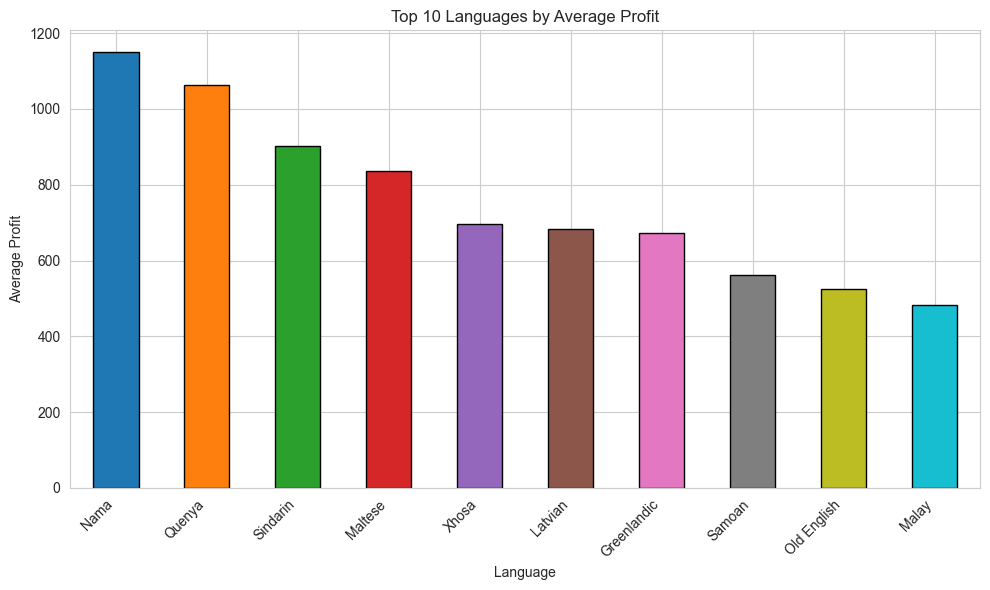

In [27]:
languages_profit_data = df[['Language', 'profit']].copy()

languages_profit_data['Language'] = languages_profit_data['Language'].str.split('~')
languages_profit_data = languages_profit_data.explode('Language')

language_avg_profit = languages_profit_data.groupby('Language')['profit'].mean().sort_values(ascending=False)
top_10_languages = language_avg_profit.head(10)
colors = plt.cm.tab10(np.linspace(0, 1, len(top_10_languages)))

plt.figure(figsize=(10, 6))
top_10_languages.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Languages by Average Profit')
plt.xlabel('Language')
plt.ylabel('Average Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


These lanuages are not the languages we expect. Let's see how many times these languages are repeated in our dataset

In [138]:
language_counts = languages_profit_data['Language'].value_counts()

print(language_counts.loc[top_10_languages.index])

Language
Nama           1
Quenya         1
Sindarin       3
Maltese        1
Xhosa          9
Latvian        1
Greenlandic    1
Samoan         1
Old English    5
Malay          2
Name: count, dtype: int64


The counts of top 10 profitable languages are so small so these are outliers. So They have to be dropped.

Top 10 Languages and Their Frequencies:
Language
Portuguese     57
Mandarin      126
Ukrainian      66
Japanese      212
Latin         151
Russian       271
Swedish        52
Hindi          54
Arabic        145
Italian       283
Name: count, dtype: int64


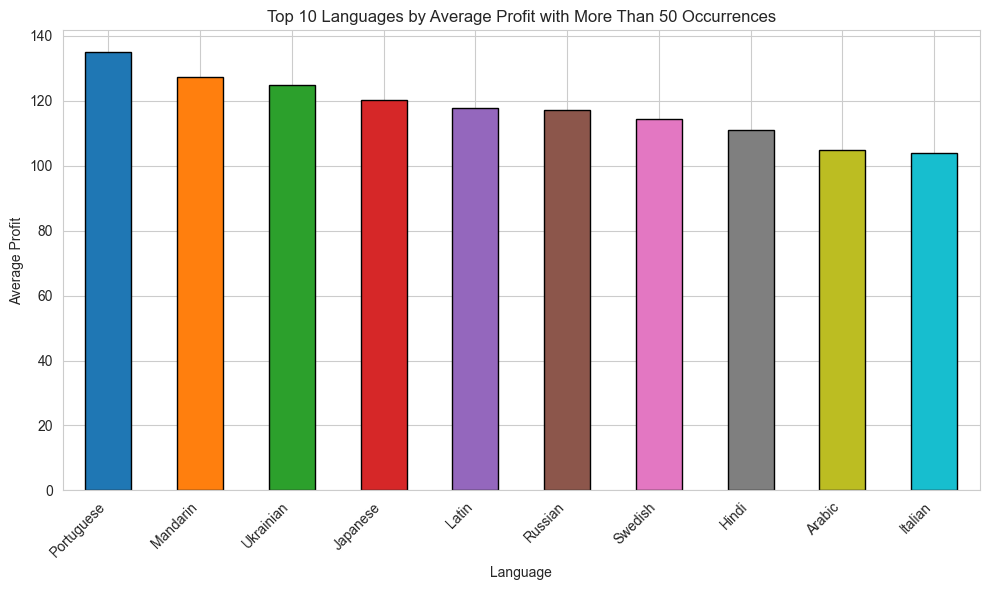

In [139]:
frequent_languages = language_counts[language_counts > 50].index
language_avg_profit = languages_profit_data[languages_profit_data['Language'].isin(frequent_languages)]
language_avg_profit = language_avg_profit.groupby('Language')['profit'].mean().sort_values(ascending=False)

top_10_languages = language_avg_profit.head(10)

top_10_language_counts = language_counts.loc[top_10_languages.index]
print("Top 10 Languages and Their Frequencies:")
print(top_10_language_counts)

colors = plt.cm.tab10(np.linspace(0, 1, len(top_10_languages)))

plt.figure(figsize=(10, 6))
top_10_languages.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Languages by Average Profit with More Than 50 Occurrences')
plt.xlabel('Language')
plt.ylabel('Average Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


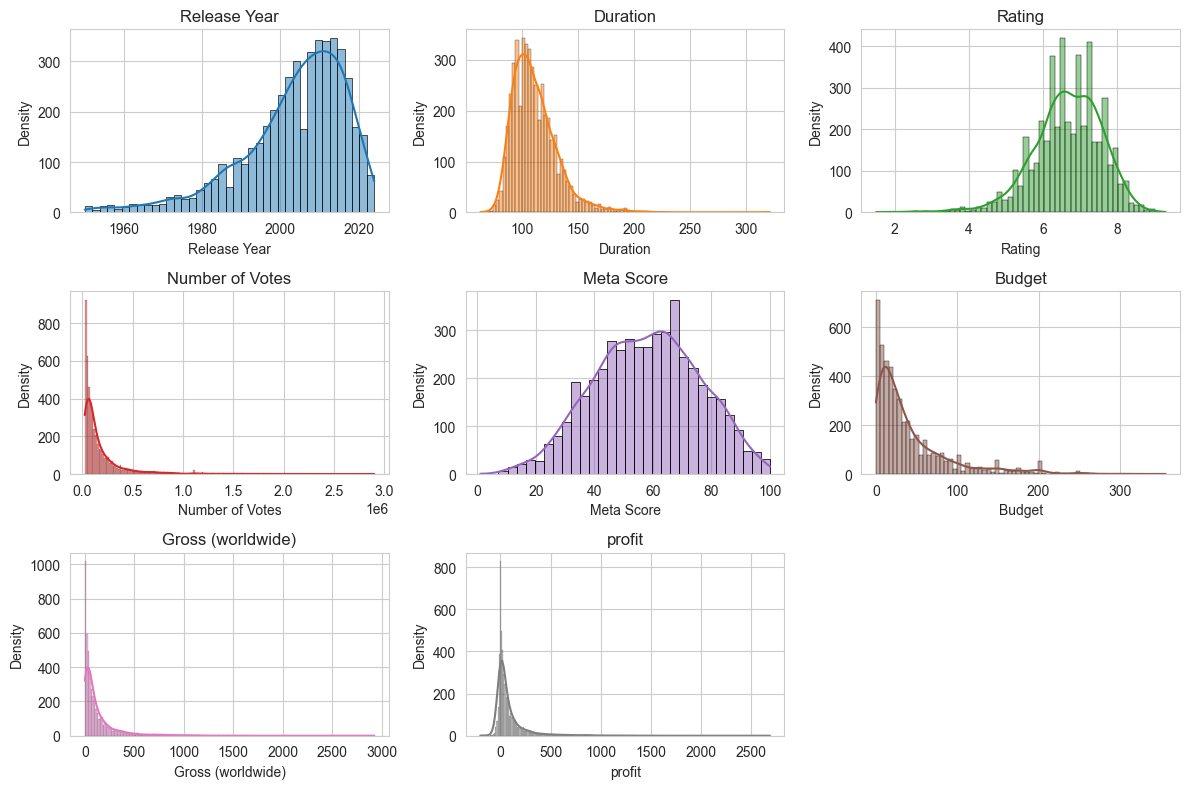

In [140]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=df, x=col, kde=True, color=colors[i], edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

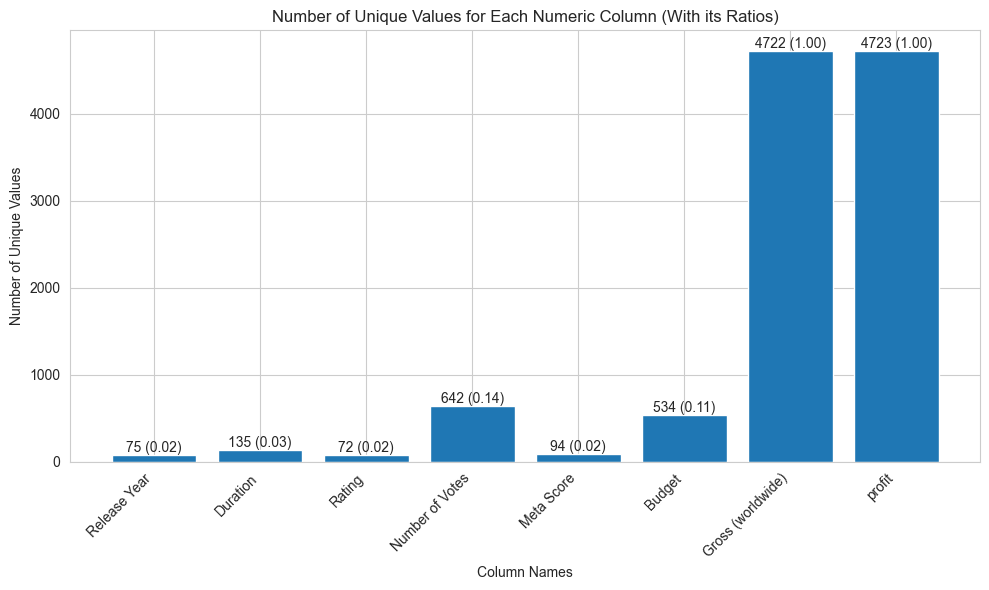

In [141]:
column_names = []
unique_value_counts = []
ratios = []

for column in numeric_columns.columns:
    column_names.append(column)
    unique_count = len(df[column].value_counts())
    unique_value_counts.append(unique_count)
    ratio = unique_count / len(df)
    ratios.append(ratio)

plt.figure(figsize=(10, 6))
bars = plt.bar(column_names, unique_value_counts)
plt.xlabel('Column Names')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values for Each Numeric Column (With its Ratios)')
plt.xticks(rotation=45, ha='right')

for bar, count, ratio in zip(bars, unique_value_counts, ratios):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count} ({ratio:.2f})', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Normalizing the data:

In [142]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = df.select_dtypes(include=['int', 'float'])
print(numeric_columns.head().columns)
df[numeric_columns.columns] =  MinMaxScaler().fit_transform(numeric_columns)

numeric_columns = df[numeric_columns.columns]

Index(['Release Year', 'Duration', 'Rating', 'Number of Votes', 'Meta Score',
       'Budget', 'Gross (worldwide)', 'profit'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

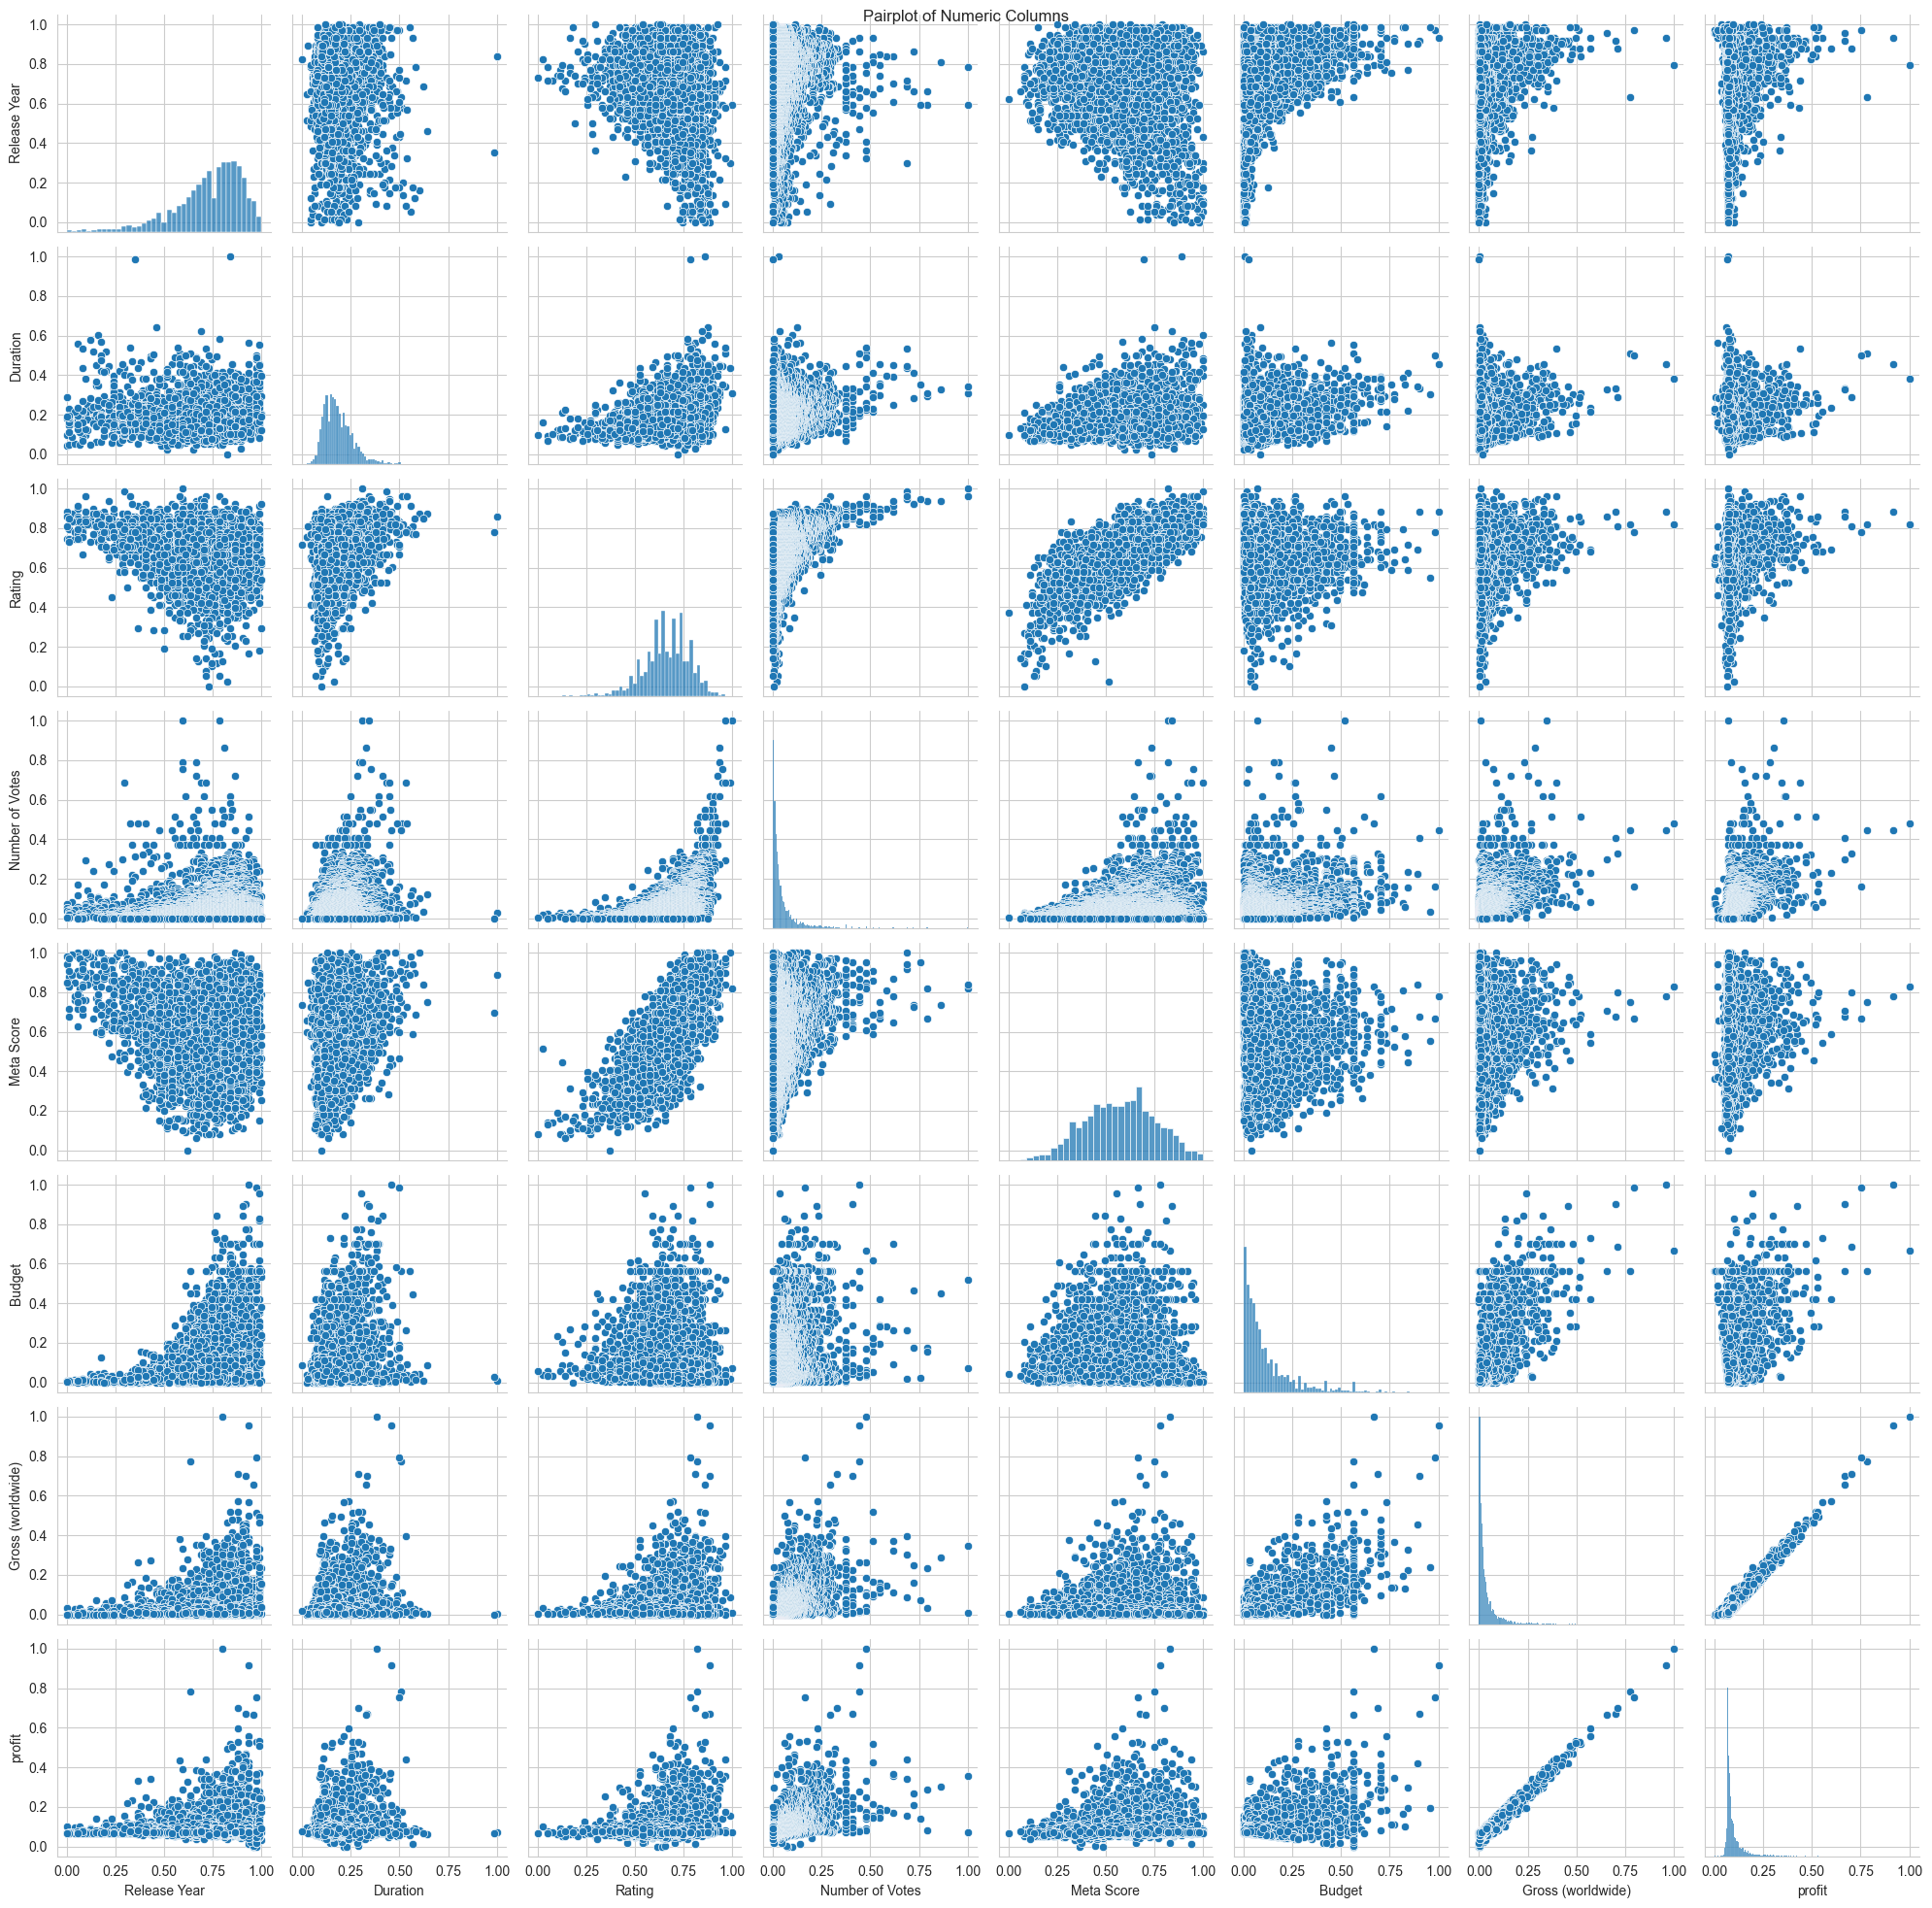

In [143]:
plt.figure(figsize=(10, 10))
sns.pairplot(data=numeric_columns)
plt.suptitle('Pairplot of Numeric Columns')
plt.tight_layout()
plt.show()



In the past, most people who voted for movies tended to give higher ratings. As the years have passed, we observe that ratings have become more spread out, with lower ratings also becoming more common.

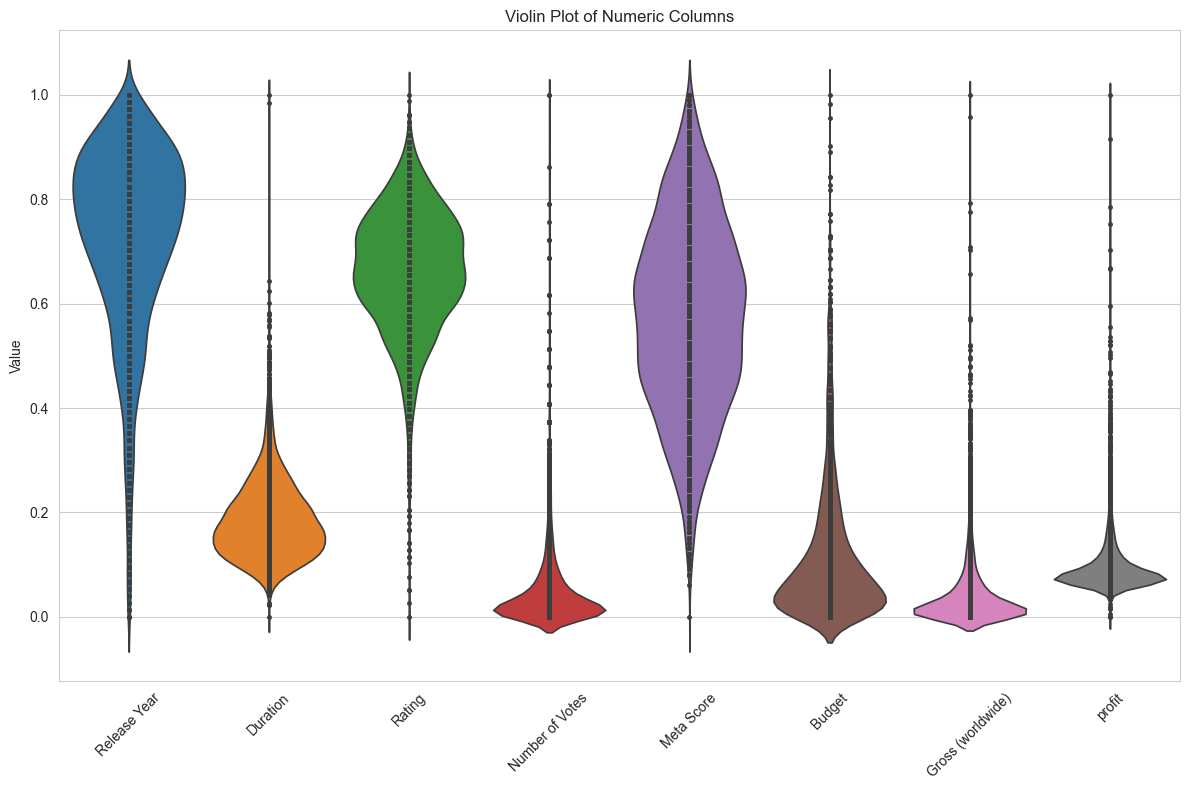

In [144]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=numeric_columns, orient='v', inner='point')
plt.title('Violin Plot of Numeric Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
